In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_table("../data/Aminer/AP_train.tsv", 
                   sep = "\t+", index_col = 0, engine = 'python')

In [4]:
# save to pickle for faster loading in future
df.to_pickle("../data/Aminer/AP_train.pickle")

In [2]:
dfo = pd.read_pickle("../data/Aminer/AP_train.pickle")

In [42]:
n_rows = dfo.shape[0]
n_rows

1976815

In [116]:
def sub(w):
    if w == 0:
        tdf = dfo
        tnr = n_rows
    else:
        tdf = dfo[:w]
        tnr = w
    return tdf, tnr

# 1a

In [71]:
df = sub(0)

In [72]:
authors = [author.split(';') for author in df[df['authors'].notnull()]['authors']]

In [73]:
n_authors = len(set([name for author in authors for name in author]))

In [74]:
n_venues = len(set(df['venue']))

In [75]:
n_pubs = df[['title', 'authors', 'year', 'venue']].drop_duplicates().shape[0]

In [76]:
references = [ref.split(',') for ref in df[df['refs'].notnull()]['refs']]

In [77]:
n_refs = len(set([ref for reference in references for ref in reference]))

In [78]:
print("Total distinct authors:\t", n_authors)
print("Total distinct venues:\t", n_venues)
print("Total publications:\t", n_pubs)
print("Total citations:\t", n_refs)

Total distinct authors:	 1483290
Total distinct venues:	 255808
Total publications:	 1964961
Total citations:	 871089


# 1b

In [165]:
df = sub(10)

In [156]:
venue_not_null = df[df['venue'].notnull()]

In [ ]:
venue_not_null[venue_not_null['venue'].str.contains('Principles and Practice of Knowledge Discovery in Databases')]

# 1c

In [106]:
batch_size = 10000

In [117]:
df, rows = sub(0)

In [118]:
rows

1976815

In [8]:
from collections import Counter

In [119]:
auth_counter = Counter()

In [120]:
def count_authors(batch):
    #print(len(batch))
    global auth_counter
    for author in batch.str.split(';', expand=True).stack().values:
        auth_counter[author] += 1

In [121]:
for i in range(rows//batch_size + 1):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    #print(start_index, end_index)
    count_authors(df['authors'][start_index:end_index])

In [122]:
len(auth_counter)

1483290

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
counts = np.array(list(auth_counter.values()))

(array([  1.11540400e+06,   1.64361000e+05,   1.03145000e+05,
          5.64970000e+04,   2.69760000e+04,   1.20030000e+04,
          3.92800000e+03,   8.34000000e+02,   1.27000000e+02,
          1.50000000e+01]),
 array([ 0.        ,  0.30236639,  0.60473278,  0.90709918,  1.20946557,
         1.51183196,  1.81419835,  2.11656474,  2.41893113,  2.72129753,
         3.02366392]),
 <a list of 10 Patch objects>)

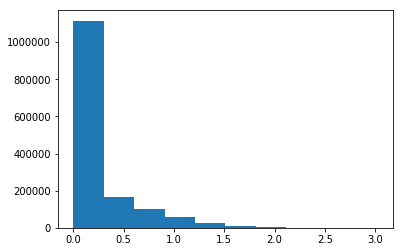

In [138]:
plt.hist(np.log10(list(auth_counter.values())))

# 1d

In [155]:
print("Number of publications per author:")
print("Mean: ", np.mean(counts), sep="\t\t\t")
print("1st quantile: ", np.percentile(counts, 25), sep="\t\t")
print("Median/2nd quantile: ", np.median(counts), sep="\t")
print("3st quantile: ", np.percentile(counts, 75), sep="\t\t")
print("Standard deviation: ", np.std(counts), sep="\t")

Number of publications per author:
Mean: 			3.28167586918
1st quantile: 		1.0
Median/2nd quantile: 	1.0
3st quantile: 		2.0
Standard deviation: 	8.83637959265


The mean and median are 